In [1]:
import pandas as pd
import numpy as np
import os
import string
import math
from time import localtime, strftime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import decomposition
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# 資料讀取、整合

In [2]:
data_dir = "./Data/"

train_x = pd.read_csv("./Data/train.csv")
test_x = pd.read_csv("./Data/test.csv")
test_y = pd.read_csv("./Data/gender_submission.csv")
train_y = train_x["Survived"]

train = train_x.set_index("PassengerId")
test = test_x.set_index("PassengerId")

df = pd.concat([train, test], axis=0, sort=False)

# 資料檢視

In [3]:
print(df.shape)
print(df.info())
print(df.describe())
print(df.isna().sum().sort_values(ascending=False))
print(df.head())

(1309, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB
None
         Survived       Pclass          Age        SibSp        Parch  \
count  891.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean     0.383838     2.294882    29.881138     0.498854     0.385027   
std      0.486592     0.837836    14.413493     1.041658     0.865560   
min      0.000

In [4]:
# Label Encoding
sex_map = {"male": 0, "female":1}
embarked_map = {"S": 0, "C":1, "Q":2}
df["Sex"] = df["Sex"].map(sex_map)
df["Embarked"] = df["Embarked"].map(embarked_map)

print(df.head())

             Survived  Pclass  \
PassengerId                     
1                 0.0       3   
2                 1.0       1   
3                 1.0       3   
4                 1.0       1   
5                 0.0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   

             SibSp  Parch            Ticket     Fare Cabin  Embarked  
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN       0.0  
2              

# EDA

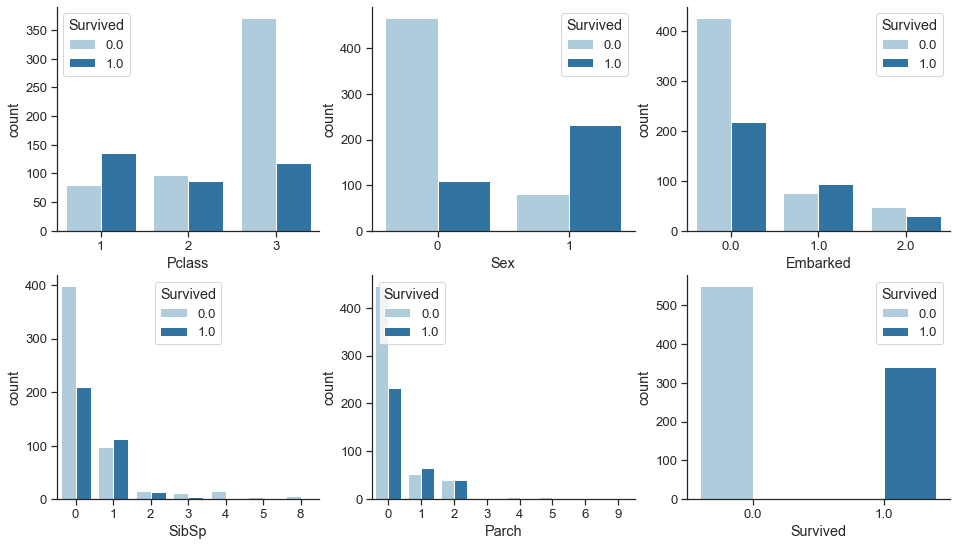

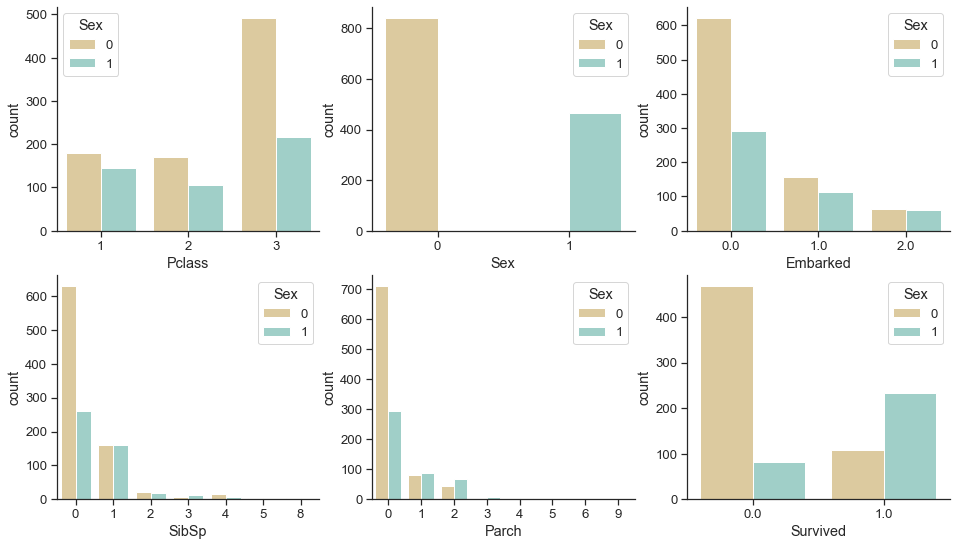

In [5]:
# 存活率與其他特徵之關聯性
columns1 = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns1):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=feature, hue='Survived', palette='Paired')
    
sns.despine()

# 性別與其他特徵之關聯性
columns2 = ['Pclass', 'Sex','Embarked','SibSp', 'Parch','Survived']
plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
sns.set_style('ticks')

for i, feature in enumerate(columns2):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=feature, hue='Sex', palette='BrBG')
    
sns.despine()  

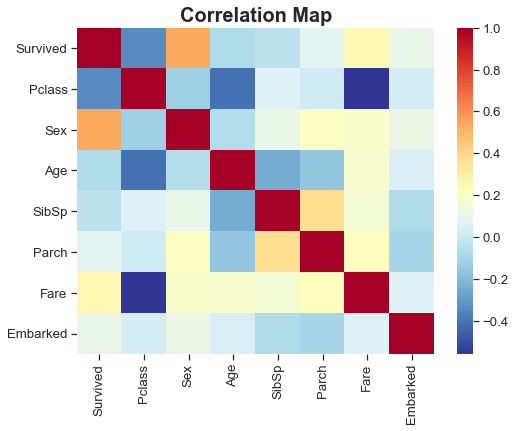

In [6]:
df_corr = df.corr()
fig, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(df_corr, cmap=plt.cm.RdYlBu_r).set_title("Correlation Map", fontdict= {'fontsize': 20, 'fontweight':'bold'})
plt.show()

In [7]:
print(df.groupby(['Pclass','Sex','Survived']).mean())
print("-"*70)
print(df.groupby(['Pclass','Sex','Survived'])["Age"].mean())
print("-"*70)
print(df.groupby(['Pclass','Sex'])["Age"].mean())
print("-"*70)
print(df.groupby(['Pclass','Sex'])['Age'].transform("mean"))

                           Age     SibSp     Parch        Fare  Embarked
Pclass Sex Survived                                                     
1      0   0.0       44.581967  0.272727  0.259740   62.894910  0.350649
           1.0       36.248000  0.377778  0.311111   74.637320  0.377778
       1   0.0       25.666667  0.666667  1.333333  110.604167  0.333333
           1.0       34.939024  0.549451  0.428571  105.978159  0.494382
2      0   0.0       33.369048  0.307692  0.142857   19.488965  0.109890
           1.0       16.022000  0.529412  0.647059   21.095100  0.117647
       1   0.0       36.000000  0.500000  0.166667   18.250000  0.000000
           1.0       28.080882  0.485714  0.642857   22.288989  0.157143
3      0   0.0       27.255814  0.523333  0.213333   12.204469  0.350000
           1.0       22.274211  0.340426  0.297872   15.579696  0.340426
       1   0.0       23.818182  1.291667  1.097222   19.773093  0.361111
           1.0       19.329787  0.500000  0.500000 

# 缺失值填補

In [8]:
print(df.describe())
print(df.info())
print(df.isna().sum().sort_values(ascending=False))

         Survived       Pclass          Sex          Age        SibSp  \
count  891.000000  1309.000000  1309.000000  1046.000000  1309.000000   
mean     0.383838     2.294882     0.355997    29.881138     0.498854   
std      0.486592     0.837836     0.478997    14.413493     1.041658   
min      0.000000     1.000000     0.000000     0.170000     0.000000   
25%      0.000000     2.000000     0.000000    21.000000     0.000000   
50%      0.000000     3.000000     0.000000    28.000000     0.000000   
75%      1.000000     3.000000     1.000000    39.000000     1.000000   
max      1.000000     3.000000     1.000000    80.000000     8.000000   

             Parch         Fare     Embarked  
count  1309.000000  1308.000000  1307.000000  
mean      0.385027    33.295479     0.394797  
std       0.865560    51.758668     0.653817  
min       0.000000     0.000000     0.000000  
25%       0.000000     7.895800     0.000000  
50%       0.000000    14.454200     0.000000  
75%       0.0

In [9]:
# 年齡與Pclass具有關聯性，用於進行缺失值填補
df["Age"].fillna(df.groupby(['Pclass','Sex'])['Age'].transform("mean"), inplace=True)
print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 155.0+ KB
None
             Survived  Pclass  \
PassengerId                     
1                 0.0       3   
2                 1.0       1   
3                 1.0       3   
4                 1.0       1   
5                 0.0       3   
...               ...     ...   
1305              NaN       3   
1306              Na

In [10]:
# Embarked缺失僅2筆，補眾數
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Fare缺失僅1筆，與Pclass相關，參考Pclass補平均值
print(df.groupby(["Pclass"]).mean())
print(df.groupby(["Pclass"])["Fare"].transform("mean"))
df["Fare"].fillna(df.groupby(["Pclass"])["Fare"].transform("mean"), inplace=True)

# Cabin遺失超過一千筆，移除不看
df.drop("Cabin", axis=1, inplace=True)

print(df.info())

        Survived       Sex        Age     SibSp     Parch       Fare  Embarked
Pclass                                                                        
1       0.629630  0.445820  39.249700  0.436533  0.365325  87.508992  0.455108
2       0.472826  0.382671  29.546381  0.393502  0.368231  21.179196  0.151625
3       0.242363  0.304654  24.811604  0.568406  0.400564  13.302889  0.461213
PassengerId
1       13.302889
2       87.508992
3       13.302889
4       87.508992
5       13.302889
          ...    
1305    13.302889
1306    87.508992
1307    13.302889
1308    13.302889
1309    13.302889
Name: Fare, Length: 1309, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age     

# 特徵工程

(20, 40]    806
(0, 20]     248
(40, 60]    222
(60, 80]     33
Name: Age, dtype: int64


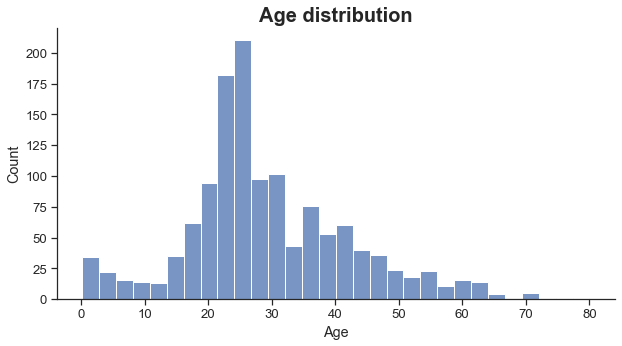

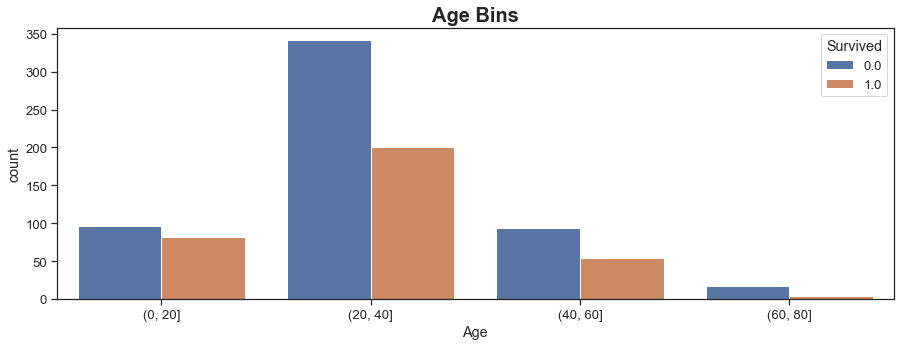

In [11]:
# 對Age進行分組
fig, axs = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Age').set_title("Age distribution",fontdict= {'fontsize': 20, 'fontweight':'bold'})
sns.despine()

# cutage = pd.cut(df['Age'], 4)  # 依數值範圍等距切4分
cutage = pd.cut(df['Age'], [0, 20, 40, 60, 80])
print(pd.value_counts(cutage))
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=cutage, hue='Survived', data=df).set_title("Age Bins",fontdict= {'fontsize': 20, 'fontweight':'bold'});
plt.show()

(-0.512, 102.466]     1225
(102.466, 204.932]      46
(204.932, 307.398]      34
(409.863, 512.329]       4
(307.398, 409.863]       0
Name: Fare, dtype: int64


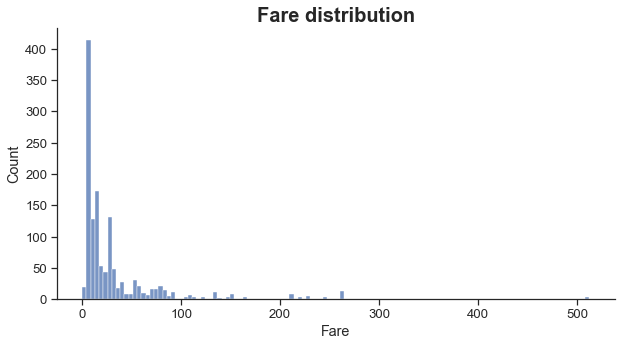

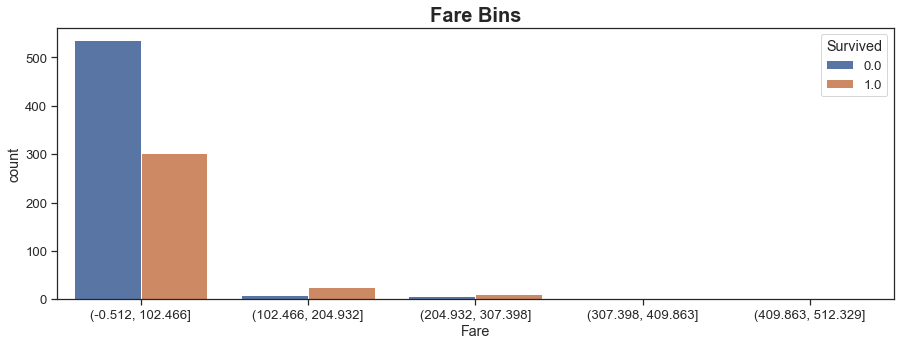

In [12]:
# 對Fare進行分組
fig, axs = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='Fare').set_title("Fare distribution",fontdict= {'fontsize': 20, 'fontweight':'bold'})
sns.despine()

cutfare = pd.cut(df['Fare'], 5)  # 依數值範圍等距切4分
# cutage = pd.cut(df['Fare'], [0, 20, 40, 60, 80])
print(pd.value_counts(cutfare))
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=cutfare, hue='Survived', data=df).set_title("Fare Bins",fontdict= {'fontsize': 20, 'fontweight':'bold'});
plt.show()

SibSp：船上兄弟姊妹+配偶；
Parch：船上父母+子女；
將二者相加合併為一特徵 -> familySize

In [13]:
df['Family'] = df['SibSp'] + df['Parch']
df.drop(["SibSp", "Parch"], axis=1, inplace=True)
print(df.head())

             Survived  Pclass  \
PassengerId                     
1                 0.0       3   
2                 1.0       1   
3                 1.0       3   
4                 1.0       1   
5                 0.0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   

                       Ticket     Fare  Embarked  Family  
PassengerId                                               
1                   A/5 21171   7.2500       0.0       1  
2                    PC 17599  71.2833       1.0   

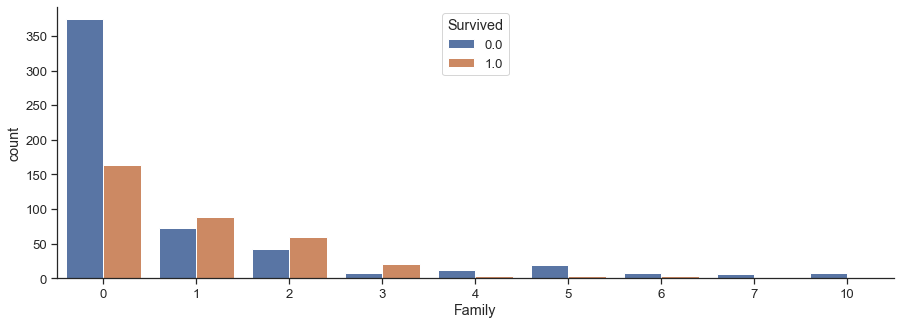

In [14]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x='Family', hue='Survived', data=df)
sns.despine()

(-1, 0]    790
(0, 3]     437
(3, 6]      63
(6, 10]     19
Name: Family, dtype: int64


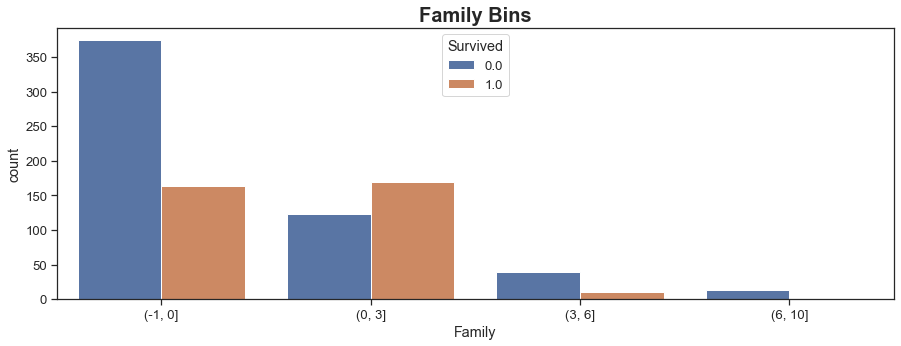

In [15]:
cutfamily = pd.cut(df['Family'], [-1, 0, 3, 6, 10])
print(pd.value_counts(cutfamily))
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=cutfamily, hue='Survived', data=df).set_title("Family Bins",fontdict= {'fontsize': 20, 'fontweight':'bold'});
plt.show()

In [16]:
# 針對Age、Fare、Family進行分組+LabelEncoding
df['Age'] = LabelEncoder().fit_transform(cutage) 
df['Fare'] = LabelEncoder().fit_transform(cutfare) 
df['Family'] = LabelEncoder().fit_transform(cutfamily) 

In [17]:
df = pd.get_dummies(df, columns=['Sex','Fare','Pclass'])
df = df.drop(["Ticket", "Name", 'Embarked'], axis = 1)
print(df.head())
print(df.columns)

             Survived  Age  Family  Sex_0  Sex_1  Fare_0  Fare_1  Fare_2  \
PassengerId                                                                
1                 0.0    1       1      1      0       1       0       0   
2                 1.0    1       1      0      1       1       0       0   
3                 1.0    1       0      0      1       1       0       0   
4                 1.0    1       1      0      1       1       0       0   
5                 0.0    1       0      1      0       1       0       0   

             Fare_3  Pclass_1  Pclass_2  Pclass_3  
PassengerId                                        
1                 0         0         0         1  
2                 0         1         0         0  
3                 0         0         0         1  
4                 0         1         0         0  
5                 0         0         0         1  
Index(['Survived', 'Age', 'Family', 'Sex_0', 'Sex_1', 'Fare_0', 'Fare_1',
       'Fare_2', 'Fare_3', 'P

In [18]:
print(df.columns)
print(df.head())
print(df.describe())
print(df.info())

Index(['Survived', 'Age', 'Family', 'Sex_0', 'Sex_1', 'Fare_0', 'Fare_1',
       'Fare_2', 'Fare_3', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')
             Survived  Age  Family  Sex_0  Sex_1  Fare_0  Fare_1  Fare_2  \
PassengerId                                                                
1                 0.0    1       1      1      0       1       0       0   
2                 1.0    1       1      0      1       1       0       0   
3                 1.0    1       0      0      1       1       0       0   
4                 1.0    1       1      0      1       1       0       0   
5                 0.0    1       0      1      0       1       0       0   

             Fare_3  Pclass_1  Pclass_2  Pclass_3  
PassengerId                                        
1                 0         0         0         1  
2                 0         1         0         0  
3                 0         0         0         1  
4                 0         1         0        

# 模型訓練

In [19]:
# I splitted df to train and test
train, test = df.loc[train.index], df.loc[test.index]

x_train = train.drop(['Survived'], axis = 1)
y_train = train["Survived"]
train_names = x_train.columns

x_test = test.drop(['Survived'], axis = 1)

In [20]:
# Scaler
standard = StandardScaler().fit(x_train)
x_train = standard.transform(x_train)
x_test = standard.transform(x_test)
print(x_train)
print(x_test)

[[-0.02300156  0.77538829  0.73769513 ... -0.56568542 -0.51015154
   0.90258736]
 [-0.02300156  0.77538829 -1.35557354 ...  1.76776695 -0.51015154
  -1.10792599]
 [-0.02300156 -0.72000341 -1.35557354 ... -0.56568542 -0.51015154
   0.90258736]
 ...
 [-0.02300156  0.77538829 -1.35557354 ... -0.56568542 -0.51015154
   0.90258736]
 [-0.02300156 -0.72000341  0.73769513 ...  1.76776695 -0.51015154
  -1.10792599]
 [-0.02300156 -0.72000341  0.73769513 ... -0.56568542 -0.51015154
   0.90258736]]
[[-0.02300156 -0.72000341  0.73769513 ... -0.56568542 -0.51015154
   0.90258736]
 [ 1.44088371  0.77538829 -1.35557354 ... -0.56568542 -0.51015154
   0.90258736]
 [ 2.90476899 -0.72000341  0.73769513 ... -0.56568542  1.96020185
  -1.10792599]
 ...
 [-0.02300156 -0.72000341  0.73769513 ... -0.56568542 -0.51015154
   0.90258736]
 [-0.02300156 -0.72000341  0.73769513 ... -0.56568542 -0.51015154
   0.90258736]
 [-0.02300156  0.77538829  0.73769513 ... -0.56568542 -0.51015154
   0.90258736]]


In [21]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_train)
print("Accuracy:%.2f" %metrics.accuracy_score(y_train, xgb_pred))

Accuracy:0.83


                 0
Sex_0     0.591577
Pclass_3  0.230605
Pclass_1  0.056694
Family    0.053071
Age       0.028328
Pclass_2  0.020767
Fare_2    0.010133
Fare_1    0.006856
Fare_0    0.001969
Sex_1     0.000000
Fare_3    0.000000


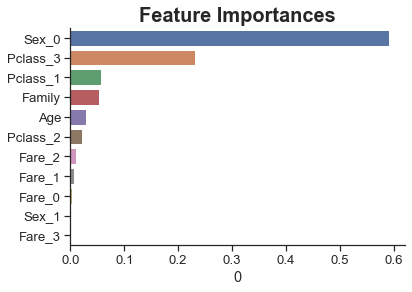

In [22]:
importances = pd.DataFrame(xgb.feature_importances_, index=train_names)
importances.sort_values(by=0, inplace=True, ascending = False)
print(importances)

sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances", fontdict= {'fontsize': 20, 'fontweight':'bold'});
sns.despine()

In [23]:
def write_result(idx, survived, filename=""):
    survived = list(map(int, survived))
    result = pd.DataFrame(columns=["PassengerId", "Survived"])
    result["PassengerId"] = idx
    result["Survived"] = survived
    result.to_csv(os.path.join("./Result/", filename), sep=",", index=False)
write_result(test_x["PassengerId"], xgb.predict(x_test), "Result_adv_0527.csv")